## Model Building Process

### Further Processing

In [1]:
#install.packages("Boruta")

In [2]:
library(WDI)
library(ggplot2)
library(gganimate)
library(tidyverse)
library(visdat)
library(repr)
library(Boruta)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


- **Load the required dataset**

In [3]:
# Read CSV file
Merged_BCI <- read.csv("./merged_data.csv")
tail(Merged_BCI)

,Year,Unemployment_Rate,GDP,Foreign_Investment,GDP_Growth,CPI,Mean_Exchange_Rate,Export_Billion,mean_CCI,mean_BCI
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26,2016,5.15,188838342528,-2772739977,3.8017580,0.6462403,1.436805,50.32,99.93822,101.10304
27,2017,4.74,206556258845,-2470087076,3.5244132,1.8507877,1.407110,56.99,100.28748,101.00427
28,2018,4.33,211886686924,-1872342297,3.5251832,1.5982970,1.444981,59.07,99.80549,99.35964
29,2019,4.11,213091987153,-4474410771,2.4459832,1.6196319,1.517566,58.22,99.45966,98.45480
30,2020,4.60,212569779570,-3413149095,-0.6539214,1.7145617,1.541536,46.21,98.96570,98.35710
31,2021,3.78,255551704626,-5609121605,5.1678474,3.9411206,1.413844,56.61,99.35504,99.70014


Upon examining the dataset, it was observed that "Foreign Investment" contains a significant number of missing values. It would be beneficial to create a plot to identify any patterns or trends in the data.

Warning message:
“Removed 9 rows containing missing values (`geom_line()`).”


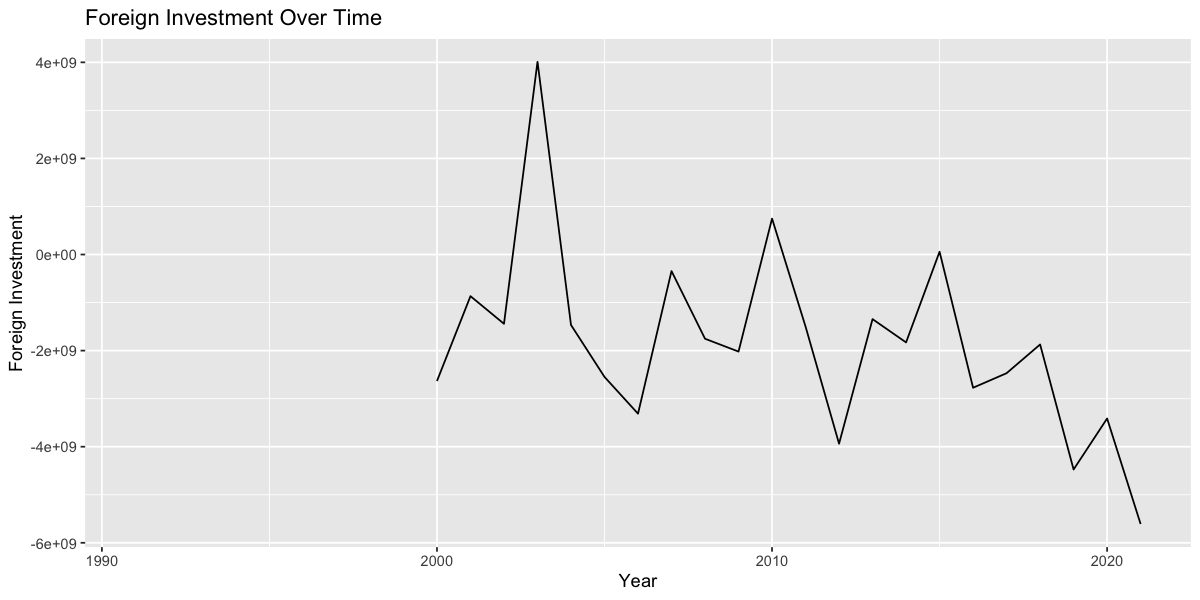

In [4]:
# Create a line plot of Year vs. Foreign_Investment

options(repr.plot.width=10, repr.plot.height=5)
ggplot(data = Merged_BCI, aes(x = Year, y = Foreign_Investment)) +
  geom_line() +
  labs(x = "Year", y = "Foreign Investment") +
  ggtitle("Foreign Investment Over Time")

It's interesting to observe that foreign investment exhibits a periodic trend. Every several years, the investment experiences a small increase, followed by a more pronounced increase. It then drops suddenly and significantly. This cycle occurs three times between 2000 and 2023. Therefore, we can use this pattern to impute the missing values before 2000.

There are a large number of missing values, which will affect data correlation testing and modeling, so the Kalman smoothing method is used to impute the missing values in the "Foreign_Investment" column.

In [5]:
library(imputeTS)

# Impute missing values in "Foreign_Investment" using the Kalman smoothing method
Merged_BCI$Foreign_Investment <- na_kalman(Merged_BCI$Foreign_Investment)

head(Merged_BCI)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



,Year,Unemployment_Rate,GDP,Foreign_Investment,GDP_Growth,CPI,Mean_Exchange_Rate,Export_Billion,mean_CCI,mean_BCI
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1991,10.61,42744828653,-2331869030,-1.090792,2.602393,1.727675,12.46,96.87869,99.18528
2,1992,10.67,41649386970,-2183022254,1.093834,1.014560,1.859296,12.99,99.41322,103.02523
3,1993,9.80,46775038749,-2037359814,6.391529,1.288208,1.849940,14.31,101.08517,103.56240
4,1994,8.35,55313381443,-1896335647,5.119248,1.745378,1.685681,17.02,102.11631,103.18218
5,1995,6.46,63916899264,-1761403687,4.722081,3.754944,1.523514,18.79,101.72528,100.27095
6,1996,6.29,70140835299,-1634017870,3.615674,2.285713,1.454756,19.88,101.40378,99.83620


All the columns in the data frame obtained through the above steps have the potential to be used to fit the model and predict the data, but in fact not so many may be used, and some are redundant. In order to reduce the amount of calculation and prevent Overfitting requires filtering the variables used to fit the model.

### Selecting Predictive Variables

Based on prior exploratory data analysis of clean datasets, we observed that employment rate trends may be significantly influenced by the following external factors:
- BCI
- Exchange Rate
- GDP
- CPI
- Export

We employ Boruta, a random forest-based feature selection method, to confirm the suitability of our chosen variables.

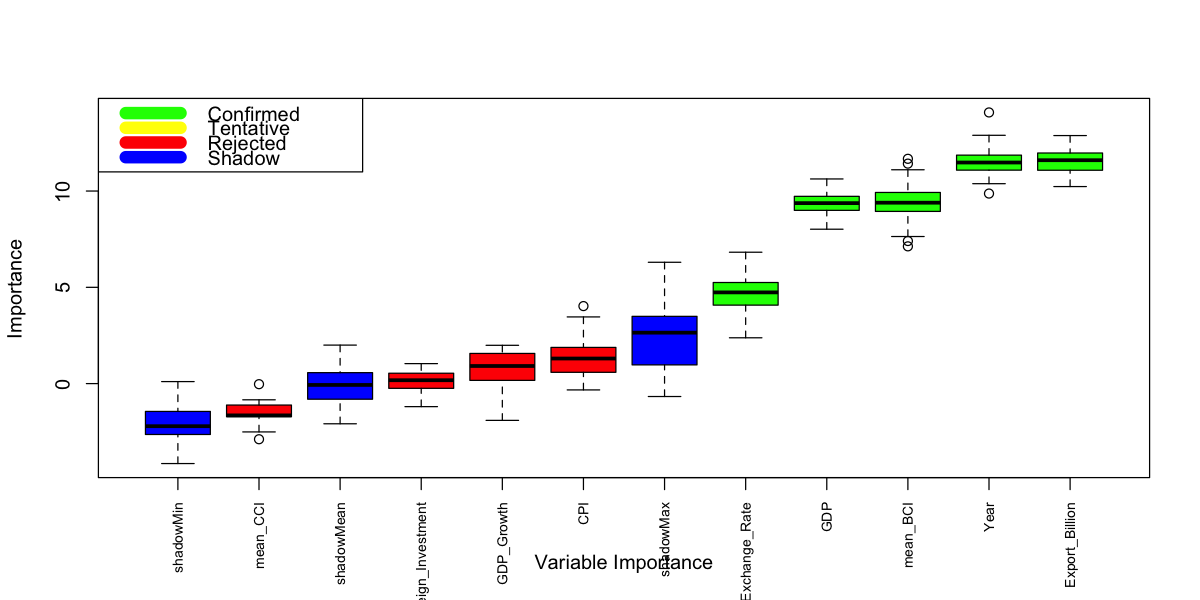

In [6]:
library(Boruta)

set.seed(2023)

# Run Boruta on the Unemployment Rate variable
results <- Boruta(Unemployment_Rate ~ ., data = Merged_BCI, maxRuns = 100)

# Plot the Boruta results
options(repr.plot.width=10, repr.plot.height=5)
plot(results, xlab = "Variable Importance", xaxt = "n")

# Extract the importance history for each variable
lz <- lapply(1:ncol(results$ImpHistory), FUN = function(i) {
  results$ImpHistory[is.finite(results$ImpHistory[, i]), i]
})
names(lz) <- colnames(results$ImpHistory)

# Sort variables by median importance
Labels <- sort(sapply(lz, median))

# Create axis labels
axis(side = 1, las = 2, labels = names(Labels), at = 1:ncol(results$ImpHistory), cex.axis = 0.7)

# Add a legend to the plot
legend('topleft', c("Confirmed", "Tentative", "Rejected", "Shadow"),
       col = c("green", "yellow", "red", "blue"), lwd = 10, xjust = 0.5, yjust = 0.5)


We can observe that **Exchange, Exports, GDP, BCI, Year** is marked as "Confirmed" and **CPI** is marked as "Tentative". These variables appear suitable for constructing a time series model. This outcome aligns with the results from our previous plot, 'Correlation of Variables with Unemployment Rate.' Consequently, we will use them as a starting point for building the model.

### Data inspection and modeling

##### (1) Check for multicollinearity

From the earlier analysis, we've identified the presence of multicollinearity in the data. Multicollinearity can lead to unstable parameter estimates and difficulty in interpretation. To address potential multicollinearity issues among variables, we will now utilize Variance Inflation Factors (VIF) for further detection.

In [7]:
# install.packages("car")
library(car)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




In [8]:
model <- lm(Unemployment_Rate ~ Export_Billion + GDP + CPI + mean_BCI + Mean_Exchange_Rate, data = Merged_BCI)
vif(model)

Export_Billion                GDP                CPI           mean_BCI 
         22.876808          22.005454           1.326076           1.371212 
Mean_Exchange_Rate 
          2.038271

The VIF results indicate that both **Export_Billion** (VIF: 22.88) and **GDP** (VIF: 22.01) have VIF values exceeding 10, which suggests a high degree of collinearity. On the other hand, the VIF values for other variables, namely CPI, mean_BCI, and Mean_Exchange_Rate, are below 10, signifying lower correlation with the other predictor variables. To address this issue, we conducted a test after removing the **GDP** variable.

In [9]:
model <- lm(Unemployment_Rate ~ Export_Billion + CPI + mean_BCI + Mean_Exchange_Rate, data = Merged_BCI)

vif(model)

Export_Billion                CPI           mean_BCI Mean_Exchange_Rate 
          2.072161           1.317177           1.341125           2.038271

The results show that we can use the four variables **Export_Billion, CPI, mean_BCI, Mean_Exchange_Rate** to fit the model.

**Regression Target:**  
We will build a regression model to predict Unemployment Rate in NZ.

**Regression Strategy:**  
Our model will include the following:
- Dependent variable y: Unemployment_Rate
- Regression variable matrix X will contain four variables:
  1. Export_Billion
  2. CPI
  3. mean_BCI
  4. Mean_Exchange_Rate

##### (2) Time Series Analysis

- Create Time Series

In [10]:
library(tseries)


Attaching package: ‘tseries’


The following object is masked from ‘package:imputeTS’:

    na.remove




In [11]:
# Use the `ts` function to create a time series object
start_year <- 1991
frequency <- 1  # The frequency of annual data is 1

Unemployment_Rate_ts <- ts(Merged_BCI$Unemployment_Rate, start=start_year, frequency=frequency)
Export_Billion_ts <- ts(Merged_BCI$Export_Billion, start=start_year, frequency=frequency)
CPI_ts <- ts(Merged_BCI$CPI, start=start_year, frequency=frequency)
mean_BCI_ts <- ts(Merged_BCI$mean_BCI, start=start_year, frequency=frequency)
Mean_Exchange_Rate_ts <- ts(Merged_BCI$Mean_Exchange_Rate, start=start_year, frequency=frequency)

- Plot Time series

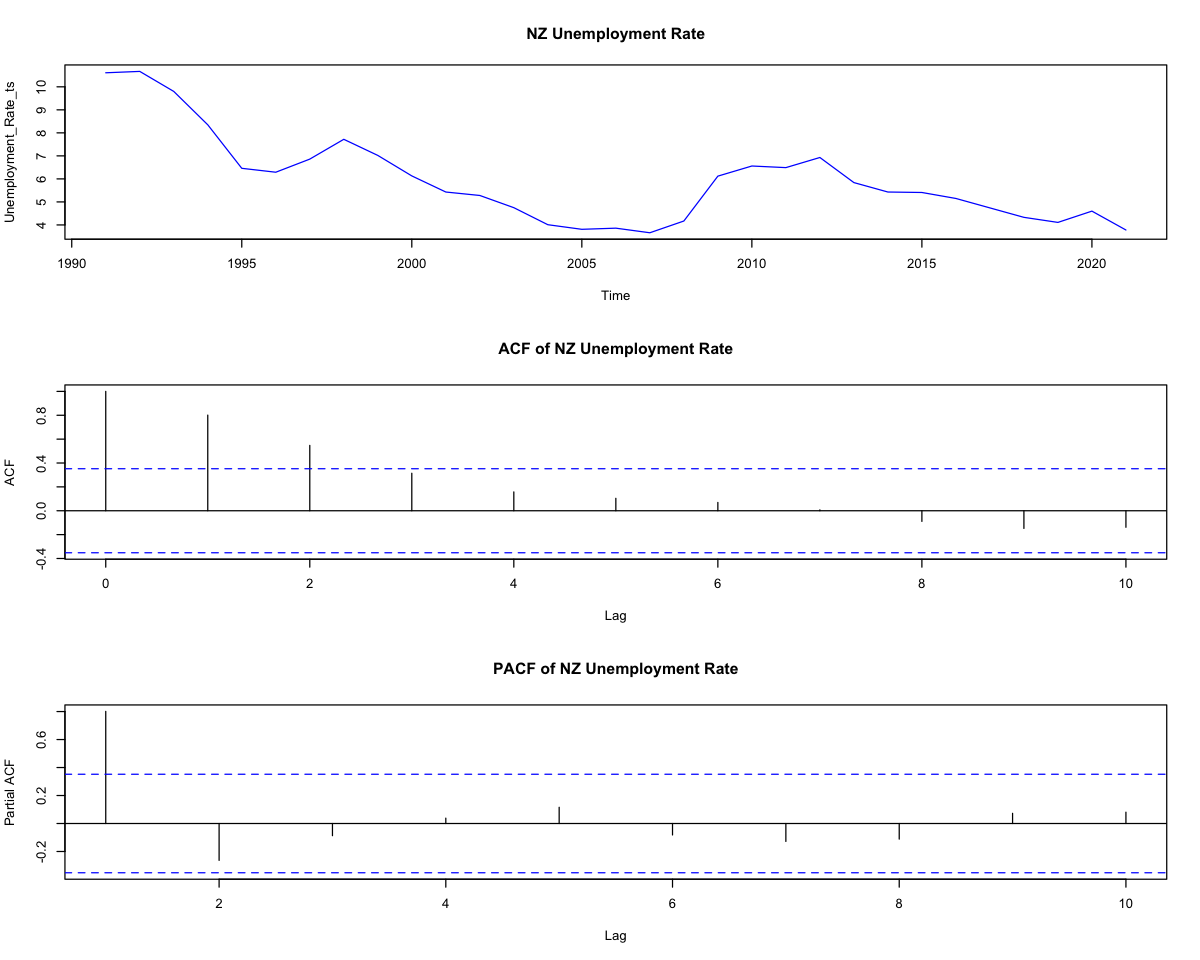

In [12]:
# Plot Unemployment Rate
options(repr.plot.width=10, repr.plot.height=8)
par(mfrow=c(3,1)) 
plot(Unemployment_Rate_ts, type="l", col="blue", main="NZ Unemployment Rate")
acf(Unemployment_Rate_ts, lag.max=10, main="ACF of NZ Unemployment Rate")
pacf(Unemployment_Rate_ts, lag.max=10, main="PACF of NZ Unemployment Rate")

From the time series plot, it can be observed that as time progresses, the unemployment rate shows a declining trend. The ACF displays a "tailing off" characteristic, where the autocorrelation gradually reduces to an insignificance level. The PACF cuts off after a lag of 1. Due to the evident trend and non-stationarity, it might be beneficial to attempt a first-order differencing on the data to eliminate the trend and achieve stationarity.

Next, plot the time series of all external factors that affect the employment rate

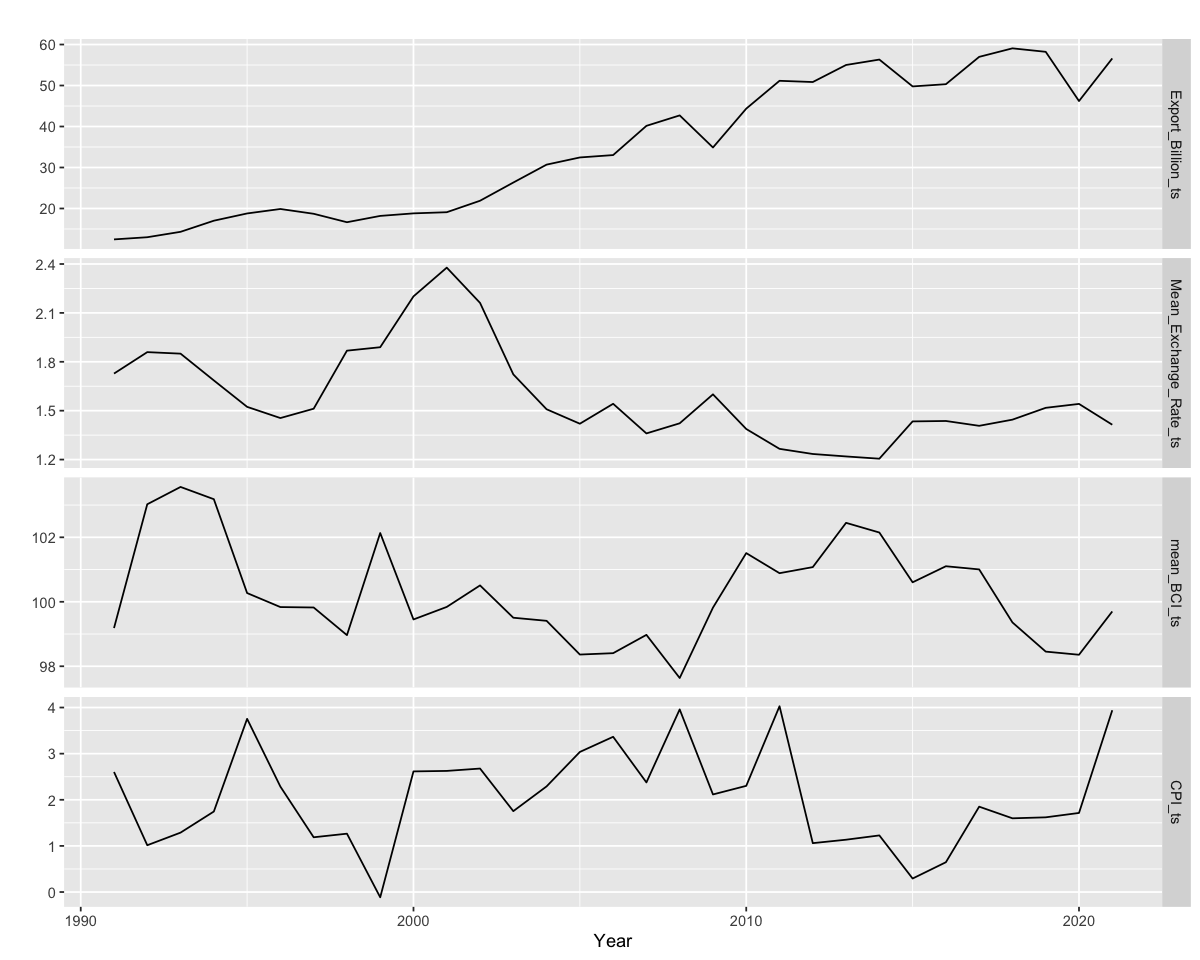

In [13]:
library(forecast)
# Plot other external time series variables
options(repr.plot.width=10, repr.plot.height=8)
# Combine all time series into a matrix
multi_ts <- cbind( Export_Billion_ts, Mean_Exchange_Rate_ts, mean_BCI_ts, CPI_ts)

# Create plots using autoplot
autoplot(multi_ts, facets = TRUE) +
  xlab("Year") + ylab("")

It can be seen from the time series diagram that all time series may have non-stationary characteristics. Next, KPSS test will be used to check the stationarity of all time series.

- Time series stationarity analysis

All X variables as well as Y variables should exhibit stationarity before applying a time series model such as an ARIMA or ARIMAX model.


Time series analysis is very sensitive to the stationarity of the data, so it is crucial to perform a stationarity test first. KPSS test is one of them.
Our main focus is on comparing KPSS statistics to key values:
- If the KPSS statistic is less than a predetermined critical value (e.g., 1%, 5%, or 10% significance level), we do not reject the null hypothesis, which indicates that the data are stationary.
- If the KPSS statistic is greater than or equal to the key value, we reject the null hypothesis, which indicates that the data is non-stationary.

In [14]:
# install.packages("urca")

In [15]:
library(urca) # For KPSS test

(a) Perform KPSS test on variable

In [16]:
Unemployment_Rate_ts %>%
  ur.kpss() %>%
  summary()

Export_Billion_ts %>%
  ur.kpss() %>%
  summary()

Mean_Exchange_Rate_ts %>%
  ur.kpss() %>%
  summary()

mean_BCI_ts %>%
  ur.kpss() %>%
  summary()

CPI_ts %>%
  ur.kpss() %>%
  summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.6208 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 1.0843 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.4999 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.1567 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.0976 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


According to the Value of test-statistic, some variable data appear to be non-stationary. For data consistency we performed first differences on all variables.

(b) Perform the KPSS test again after the first difference of the variables.

In [17]:
# Differentiation Process
Unemployment_Rate_diff <- diff(Unemployment_Rate_ts) 
Export_Billion_diff <- diff(Export_Billion_ts) 
Mean_Exchange_Rate_diff <- diff(Mean_Exchange_Rate_ts) 
mean_BCI_diff <- diff(mean_BCI_ts) 
CPI_diff <- diff(CPI_ts) 

In [18]:
Unemployment_Rate_diff %>%
  ur.kpss() %>%
  summary()

Export_Billion_diff %>%
  ur.kpss() %>%
  summary()

Mean_Exchange_Rate_diff %>%
  ur.kpss() %>%
  summary()

mean_BCI_diff %>%
  ur.kpss() %>%
  summary()

CPI_diff %>%
  ur.kpss() %>%
  summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.1741 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.0859 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.0558 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.067 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 2 lags. 

Value of test-statistic is: 0.1185 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Now the variables after the first difference meet the requirements of stationarity.

### Fitting a Time Series Model

Because there's a need to model the relationship between the time series and one or more external predictors, while also accounting for the autocorrelation in the residuals, the regARIMA model is quite suitable. It is a method that combines regression analysis with ARIMA (AutoRegressive Integrated Moving Average) time series modeling.

In [19]:
# Fitting a regARIMA time series model
fit <- auto.arima(Unemployment_Rate_diff, xreg = cbind(Export_Billion_diff, Mean_Exchange_Rate_diff, mean_BCI_diff, CPI_diff))

In [20]:
fit

Series: Unemployment_Rate_diff 
Regression with ARIMA(1,0,0) errors 

Coefficients:
         ar1  Export_Billion_diff  Mean_Exchange_Rate_diff  mean_BCI_diff
      0.6321              -0.0428                   1.1782         0.0138
s.e.  0.1360               0.0225                   0.6651         0.0635
      CPI_diff
       -0.1497
s.e.    0.0771

sigma^2 = 0.263:  log likelihood = -20.06
AIC=52.11   AICc=55.77   BIC=60.52

Here, the best ARIMA model is automatically selected to fit the time series data by using the auto.arima() function. This function determines the best model by comparing the AIC (Akaike Information Criterion) of different ARIMA models. ARIMA(1,0,0) is the best model, which is the AR(1) model.

Coefficient of AR(1):0.6321  
Export_Billion_diff:-0.0428  
Mean_Exchange_Rate_diff:1.1782  
mean_BCI_diff:0.0138  
CPI_diff:-0.1497

Next, check whether the model residuals are consistent with white noise.


	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,0,0) errors
Q* = 7.8776, df = 5, p-value = 0.1631

Model df: 1.   Total lags used: 6



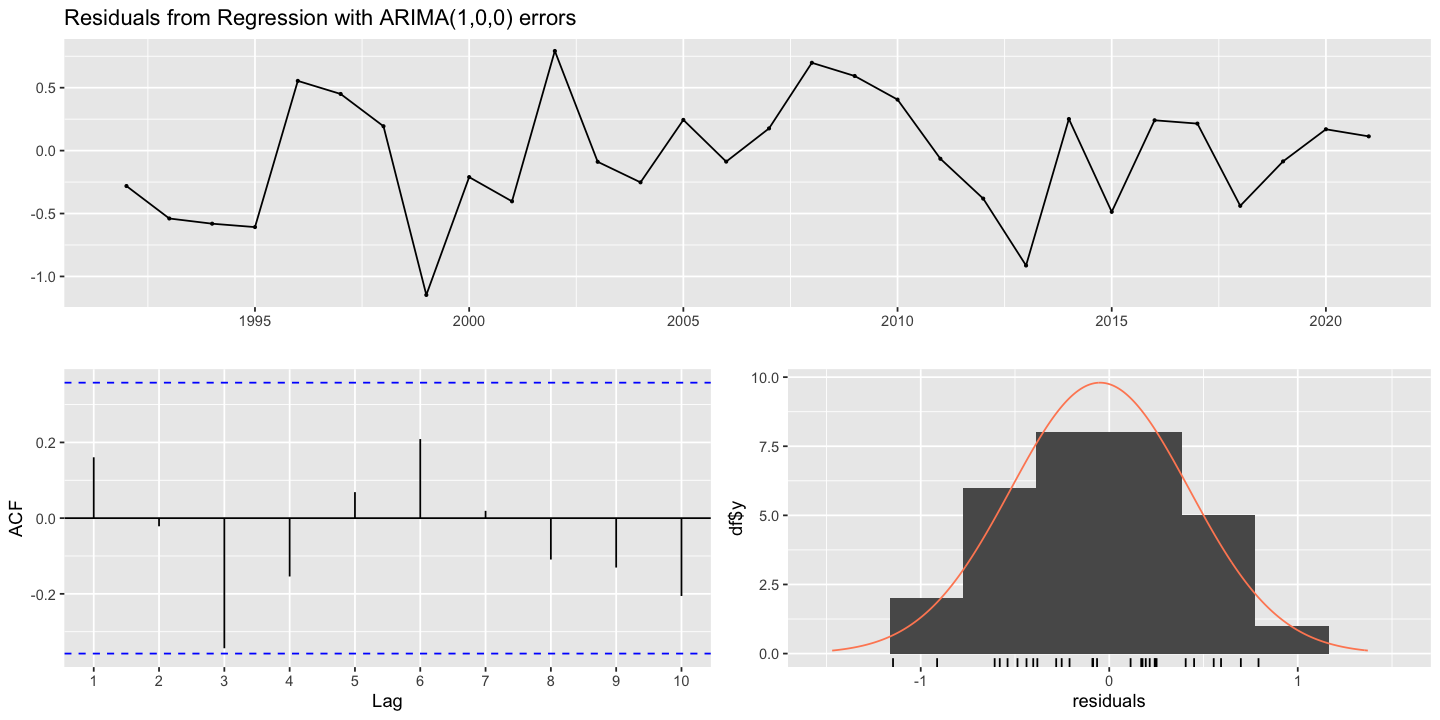

In [21]:
options(repr.plot.width=12, repr.plot.height=6)
checkresiduals(fit)

The residual analysis reveals that the residuals are evenly distributed on both sides of zero without any discernible pattern, and their distribution tends towards normality. Therefore, the fitted model's residuals meet the white noise assumption.

Next, we'll fit a model to the data and compare it to the actual values.

In [22]:
# Calculate fitted values from the time series model
fitted_values <- fitted(fit)

# Assume the differencing level is 1
diff_level <- 1

# Calculate the de-differenced fitted values
fitted_original <- numeric(length(Unemployment_Rate_ts))
fitted_original[1:(diff_level)] <- Unemployment_Rate_ts[1:(diff_level)]

# De-differencing
for (i in (diff_level + 1):length(Unemployment_Rate_ts)) {
  fitted_original[i] <- Unemployment_Rate_ts[i - diff_level] + fitted_values[i - diff_level]
}

# Create a time series with the de-differenced values
fitted_original <- ts(round(fitted_original, 2), start = 1991)

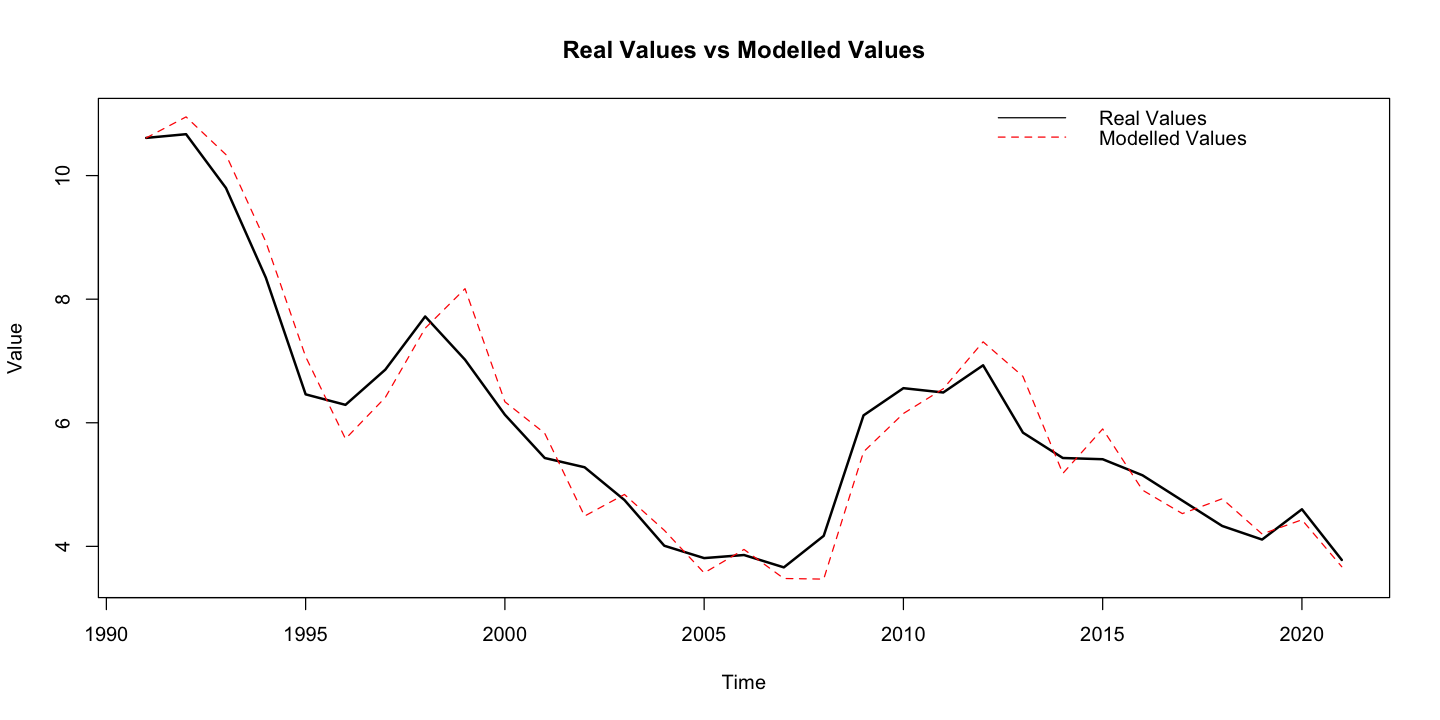

In [23]:
options(repr.plot.width=12, repr.plot.height=6)

# Plot the actual unemployment rate data
plot(Unemployment_Rate_ts, type="l", lwd=2,
     main="Real Values vs Modelled Values", ylab="Value", xlab="Time",
     ylim=range(c(Unemployment_Rate_ts, fitted_original))) # Set the y-axis range to encompass all values from both sequences

# Add model-fitted values to the plot
lines(fitted_original, col="red", lty=2)

# Add a legend
legend("topright", legend=c("Real Values", "Modelled Values"),
       col=c("black", "red"), lty=c(1,2), bty="n")


From the plot of fitted values and actual values, we can see that the fitting results are similar to the original time series.

Forecast the employment rate for the next two years

In [24]:
# Use autoregressive models to forecast the next differenced value for each external regression variable.
model_Export_Billion_diff <- auto.arima(Export_Billion_diff)
model_Mean_Exchange_Rate_diff <- auto.arima(Mean_Exchange_Rate_diff)
model_mean_BCI_diff <- auto.arima(mean_BCI_diff)
model_CPI_diff <- auto.arima(CPI_diff)

# Two-Step Forecasting for External Regressors
forecast_Export_Billion_diff_2steps <- forecast(model_Export_Billion_diff, h=2)$mean
forecast_Mean_Exchange_Rate_diff_2steps <- forecast(model_Mean_Exchange_Rate_diff, h=2)$mean
forecast_mean_BCI_diff_2steps <- forecast(model_mean_BCI_diff, h=2)$mean
forecast_CPI_diff_2steps <- forecast(model_CPI_diff, h=2)$mean

In [25]:
# Construct the matrix of future external regression variables.
future_xreg_2steps <- matrix(c(forecast_Export_Billion_diff_2steps, forecast_Mean_Exchange_Rate_diff_2steps, forecast_mean_BCI_diff_2steps, forecast_CPI_diff_2steps), ncol=4)

# Using these predicted values, forecast the two future time points for the main time series.
forecasted_diff_values_2steps <- forecast(fit, xreg=future_xreg_2steps, h=2)
forecasted_diff_values_2steps

Warning message in forecast.forecast_ARIMA(fit, xreg = future_xreg_2steps, h = 2):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”


     Point Forecast      Lo 80     Hi 80      Lo 95    Hi 95
2022     0.28556739 -0.3717144 0.9428491 -0.7196583 1.290793
2023    -0.02548484 -0.8030639 0.7520942 -1.2146894 1.163720

The above result is the prediction of the original time series after the first difference. Next, we need to remove the first difference to get the real prediction value.

In [26]:
# Take the inverse difference to obtain the original forecasted values
forecasted_original_values_2steps <- numeric(2)
forecasted_original_values_2steps[1] <- tail(Unemployment_Rate_ts, n=1) + forecasted_diff_values_2steps$mean[1]
forecasted_original_values_2steps[2] <- forecasted_original_values_2steps[1] + forecasted_diff_values_2steps$mean[2]

In [27]:
# Extract the 95% confidence interval for the predicted differences.
lower_diff_2steps <- forecasted_diff_values_2steps$lower[,2]
upper_diff_2steps <- forecasted_diff_values_2steps$upper[,2]

# Lower Bound of the 95% Confidence Interval
lower_original_2steps <- numeric(2)
lower_original_2steps[1] <- tail(Unemployment_Rate_ts, n=1) + lower_diff_2steps[1]
lower_original_2steps[2] <- lower_original_2steps[1] + lower_diff_2steps[2]

# Upper Bound of the 95% Confidence Interval
upper_original_2steps <- numeric(2)
upper_original_2steps[1] <- tail(Unemployment_Rate_ts, n=1) + upper_diff_2steps[1]
upper_original_2steps[2] <- upper_original_2steps[1] + upper_diff_2steps[2]

# Output the 95% confidence interval after differencing
Output_df <- data.frame(
  Year = c("2022", "2023"),
  predicted = forecasted_original_values_2steps,
  lower_95 = lower_original_2steps,
  upper_95 = upper_original_2steps
)
Output_df

Year,predicted,lower_95,upper_95
<chr>,<dbl>,<dbl>,<dbl>
2022,4.065567,3.060342,5.070793
2023,4.040083,1.845652,6.234513
